In [2]:
%pylab inline

import pres_style, os
import pyfits as pyf
from PyTools import integrated_flux

Populating the interactive namespace from numpy and matplotlib


In [12]:
snr_written = True
rds_written = True

sdir = "/home/mejia/Programs/master/inputs/"

wls, sg = loadtxt(sdir+"SDSSERROR.DAT", unpack=True)
wls, sg = wls[(wls>=3850)&(wls<=9150)], sg[(wls>=3850)&(wls<=9150)]
wlj = loadtxt("../inputs/real_deal7/nem_jpas/processed_nem_JPAS_spSpec-52319-0786-277.txt", usecols=(0,))

true_params = genfromtxt(sdir+"SSAG_catalog.txt", dtype=None, names=True, usecols=range(1,55))
names = genfromtxt(sdir+"SSAG_catalog.txt", dtype=str, usecols=(0,))
names = array([name+".fits.gz" for name in names], dtype=str)

Z_rich = (log10(true_params["Z"])>0.3)&(true_params["V"]-true_params["pV"]<0.5)&(true_params["rfwla"]>9)

sed_list = sorted([file for root, subs, files in os.walk(sdir+"SSAG/") for file in files if file.endswith(".fits.gz") and file in names[Z_rich]])

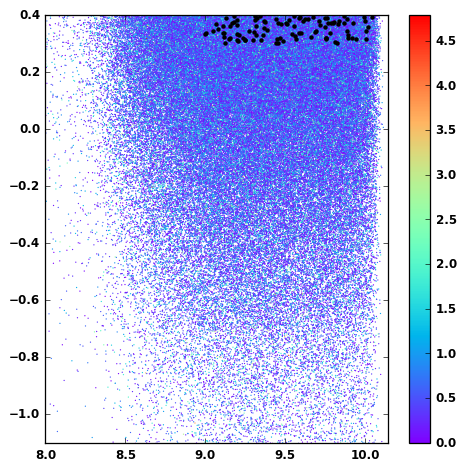

In [16]:
xlim(8, 10.14)
ylim(-1.1, 0.4)

N = 100

scatter(true_params["rfwla"], log10(true_params["Z"]), c=true_params["V"]-true_params["pV"], cmap=cm.rainbow, lw=0, s=1)
plot(true_params["rfwla"][Z_rich][:N], log10(true_params["Z"])[Z_rich][:N], ".k")
colorbar()

In [3]:
def integrated_flux(SED, passband):
    mask = (passband[0, 0] <= SED[:, 0])&(SED[:, 0] <= passband[-1, 0])
  
    if mask.sum()==0: return 0.0

    resolution = mean(diff(SED[mask, 0]))
    if mask.sum()<0.95/resolution*(passband[-1, 0]-passband[0, 0]): return 0.0

    ipassband = interp(SED[mask, 0], passband[:, 0], passband[:, 1])

    return trapz(SED[mask, 1]*ipassband, SED[mask, 0])/trapz(ipassband, SED[mask, 0])

def error_propagation(SED, passband):
    mask = (passband[0, 0] <= SED[:, 0])&(SED[:, 0] <= passband[-1, 0])

    if mask.sum()==0: return 0.0
    
    resolution = mean(diff(SED[mask, 0]))
    if mask.sum()<0.95/resolution*(passband[-1, 0]-passband[0, 0]): return 0.0
    
    ipassband = interp(SED[mask, 0], passband[:, 0], passband[:, 1])

    return sqrt(trapz((SED[mask, 1]*ipassband)**2, SED[mask, 0])/trapz(ipassband, SED[mask, 0])**2)

jpas = open("../inputs/JPAS_filters.txt").readlines()

mask = [False if item.startswith("#") else True for item in jpas]
jpas_res = []
for i in xrange(mask.count(False)):
    try:
        ini = mask.index(False); mask.remove(False)
        fin = mask.index(False)
        
        jpas_res.append(np.array([eval(item.replace("  ", ",")) for item in jpas[ini+1+i:fin+1+i]]))
        
    except ValueError:
        jpas_res.append(np.array([eval(item.replace("  ", ",")) for item in jpas[ini+1+i:]]))

In [4]:
if not snr_written:
    random.seed(0)
    for snr in [5, 15, 25]:
        for file in sed_list:
            f = pyf.open(sdir+"SFHs_set3/"+file)
            wl, fl = f[1].data["Wavelength"], f[1].data["Flux"]

            fli = interp(wls, wl, fl)
            sgs = sg / sg[argmin(abs(wls-6800))] / snr * fli
            fls = fli + random.randn(sg.size) * sgs

            flj = array([integrated_flux(column_stack((wls, fls)), res) for res in jpas_res])
            sgj = array([error_propagation(column_stack((wls, sgs)), res) for res in jpas_res])

            savetxt("../inputs/tests/Z_migrations_snr/spec/"+file.rstrip(".fits.gz")+"_SPEC_snr{0}.txt".format(snr), column_stack((wls, fls, sgs)))
            savetxt("../inputs/tests/Z_migrations_snr/jpas/"+file.rstrip(".fits.gz")+"_JPAS_snr{0}.txt".format(snr), column_stack((wlj, flj, sgj)))
            
    snr_written = True

In [5]:
if not rds_written:
    random.seed(0)
    for redshift in [0.050, 0.075, 0.100]:
        for file in sed_list:
            f = pyf.open(sdir+"SFHs_set3/"+file)
            wl, fl = f[1].data["Wavelength"], f[1].data["Flux"]

            wls_trim = wls[argmin(abs(wls-wls.min() / (1+redshift))):argmin(abs(wls-wls.max() / (1+redshift)))]
            sg_trim = sg[argmin(abs(wls-wls.min() / (1+redshift))):argmin(abs(wls-wls.max() / (1+redshift)))]

            fli = interp(wls_trim, wl, fl)
            sgs = sg_trim / sg_trim[argmin(abs(wls_trim - 6800.0))] / 15.0 * fli
            fls = fli + random.randn(sgs.size) * sgs

            flj = array([integrated_flux(column_stack((wls_trim, fls)), res) for res in jpas_res])
            sgj = array([error_propagation(column_stack((wls_trim, sgs)), res) for res in jpas_res])

            savetxt("../inputs/tests/Z_migrations_trim/spec/"+file.rstrip(".fits.gz")+"_SPEC_rds{0}.txt".format("{0:.3f}".format(redshift).replace(".", "p")), column_stack((wls_trim, fls, sgs)))
            savetxt("../inputs/tests/Z_migrations_trim/jpas/"+file.rstrip(".fits.gz")+"_JPAS_rds{0}.txt".format("{0:.3f}".format(redshift).replace(".", "p")), column_stack((wlj, flj, sgj)))
        
    rds_written = True